# **Dataset & Description**



[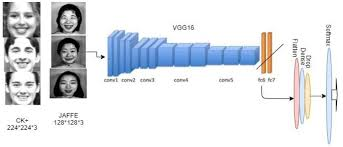](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

# Import necessary python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sn
# import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, LeakyReLU
from tensorflow.keras.models import Model, Sequential
# from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2022-11-24 22:52:50.648438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 22:52:50.748989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-24 22:52:50.749008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-24 22:52:50.768671: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-24 22:52:51.296552: W 

# Data Preprocessing

In [2]:
batch_size = 128
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Dataset/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = batch_size,
                                                   shuffle=True)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Dataset/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = batch_size)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = 'Dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = batch_size)

Found 7178 images belonging to 7 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

2022-11-24 22:52:52.554576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-24 22:52:52.554603: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 22:52:52.554618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (unmanned-arena): /proc/driver/nvidia/version does not exist
2022-11-24 22:52:52.554778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(7,activation='softmax'))

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
      tf.keras.metrics.TopKCategoricalAccuracy(k = 3, name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score
]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.50,
                        min_lr = 1e-6
                        )

mcp = ModelCheckpoint('Models/cb_vgg16_v2.h5',
                        monitor='val_acc')

es = EarlyStopping(verbose=1,
                        patience=20,
                        restore_best_weights=True #restoring the best model
                        )

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [14]:
history=model.fit(train_dataset,
                    steps_per_epoch=train_dataset.n//train_dataset.batch_size,
                    validation_data=valid_dataset,
                    validation_steps = valid_dataset.n//valid_dataset.batch_size,
                    epochs = 100,
                    verbose = 1,
                    callbacks=[lrd,mcp,es])

Epoch 1/100
179/179 [==============================] - 463s 3s/step - loss: 1.8928 - accuracy: 0.5870 - precision: 0.3567 - recall: 0.0176 - auc: 0.6386 - f1_score: 0.0335 - val_loss: 1.8527 - val_accuracy: 0.6040 - val_precision: 0.8333 - val_recall: 0.0018 - val_auc: 0.6714 - val_f1_score: 0.0035 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - 225s 1s/step - loss: 1.7502 - accuracy: 0.6405 - precision: 0.5988 - recall: 0.0257 - auc: 0.6920 - f1_score: 0.0491 - val_loss: 2.0952 - val_accuracy: 0.5657 - val_precision: 0.6667 - val_recall: 3.5511e-04 - val_auc: 0.6403 - val_f1_score: 7.0472e-04 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - 163s 910ms/step - loss: 1.6707 - accuracy: 0.6718 - precision: 0.6278 - recall: 0.0739 - auc: 0.7277 - f1_score: 0.1310 - val_loss: 1.8980 - val_accuracy: 0.6669 - val_precision: 0.3478 - val_recall: 0.2640 - val_auc: 0.7277 - val_f1_score: 0.3002 - lr: 0.0010
Epoch 4/100
179/179 [=============================

In [15]:
model.save('Models/vgg16_v4.h5')

# Data Postprocessing

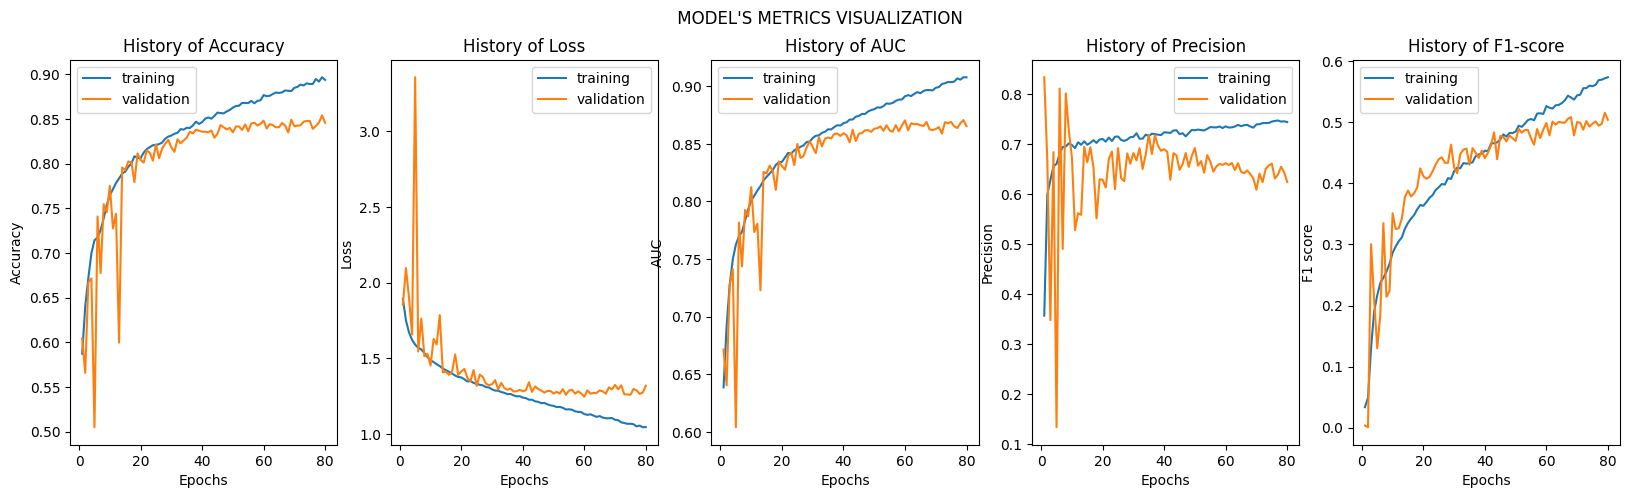

In [16]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

# Load a model

In [17]:
from tensorflow.keras.models import load_model

model = load_model('Models/vgg16_v4.h5', compile = False)
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

# Test a model

In [19]:
results = model.evaluate(test_dataset)
results

57/57 [==============================] - 18s 314ms/step - loss: 1.2459 - accuracy: 0.8475 - precision: 0.6456 - recall: 0.4158 - auc: 0.8681 - f1_score: 0.5037


[1.2458696365356445,
 0.8474628925323486,
 0.645575761795044,
 0.41576892137527466,
 0.8680796027183533,
 0.5036742091178894]

# Create Confusion Matrix

In [20]:
# Finding prediction for the test dataset
predictions = model.predict(test_dataset)

# Categorizing test dataset based on predictions
test_prediction = []
for i in range(test_dataset.samples):
    idx = np.argmax(predictions[i])
    test_prediction.append(idx)

57/57 [==============================] - 18s 317ms/step


In [21]:
# Defining labels of Confusion Matrix
emotions = test_dataset.class_indices

# Creating Confusion matrix
res = tf.math.confusion_matrix(test_prediction, test_dataset.classes).numpy()
cm = pd.DataFrame(res, index=emotions, columns=emotions)
cm

,angry,disgust,fear,happy,neutral,sad,surprise
angry,154,18,191,308,202,222,160
disgust,4,0,5,12,5,10,2
fear,103,11,111,163,123,122,79
happy,254,35,278,446,332,317,213
neutral,224,26,217,433,294,276,193
sad,100,11,88,186,106,136,82
surprise,119,10,134,226,171,164,102
